<a href="https://colab.research.google.com/github/monica959/hello_world/blob/main/Version_mejorada_de_Algoritmo_Gen%C3%A9tico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install biopython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 28.4 MB/s eta 0:00:00


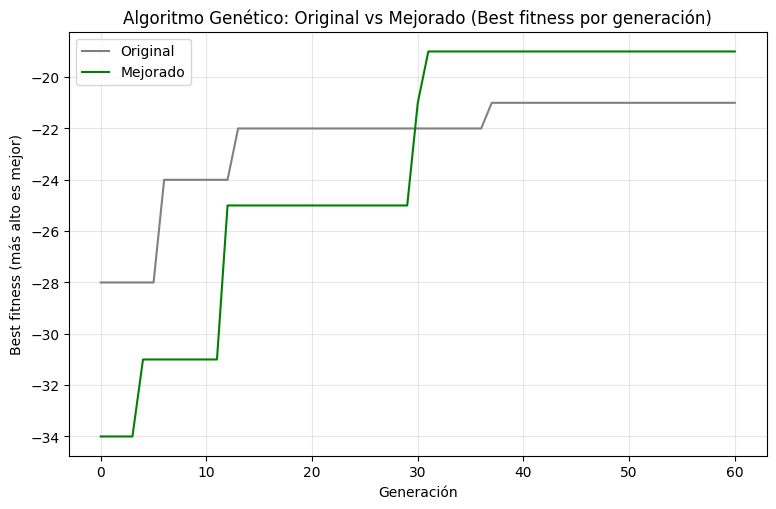

==== RESUMEN ====
Original : Best=-21.00 | NFE=5490 | Tiempo=1.581s
Mejorado : Best=-19.00 | NFE=5940 | Tiempo=4.349s


In [ ]:


# PROYECTO FINAL - Algoritmo Genético Mejorado
# Comparación: Original vs Mejorado


import time, random, math
import numpy as np
import matplotlib.pyplot as plt


# 0) Secuencias base

SEQ_A = "GATTACA"
SEQ_B = "GCATGCU"



# 1) SCORING: BLOSUM62 o simple (match/mismatch)

USE_BLOSUM = True
try:
    from Bio.SubsMat.MatrixInfo import blosum62
    BLOSUM = blosum62
except Exception:
    USE_BLOSUM = False
    BLOSUM = None

GAP_OPEN = -5
GAP_EXT  = -1

def blosum_score(a, b):
    key = (a, b)
    if key in BLOSUM:
        return BLOSUM[key]
    key = (b, a)
    if key in BLOSUM:
        return BLOSUM[key]
    return -1

def simple_score(a, b):
    return 1 if a == b else -1

def score_pairwise_alignment(alnA, alnB, use_blosum=USE_BLOSUM):
    """Evalúa el alineamiento con penalización afín de gaps."""
    assert len(alnA) == len(alnB)
    s = 0
    for a, b in zip(alnA, alnB):
        if a != '-' and b != '-':
            s += blosum_score(a, b) if use_blosum and BLOSUM else simple_score(a, b)

    def affine_gap_penalty(seq):
        total, i = 0, 0
        while i < len(seq):
            if seq[i] == '-':
                run = 1
                i += 1
                while i < len(seq) and seq[i] == '-':
                    run += 1
                    i += 1
                total += GAP_OPEN + GAP_EXT * (run - 1)
            else:
                i += 1
        return total

    s += affine_gap_penalty(alnA)
    s += affine_gap_penalty(alnB)
    return s

# 2) Representación y validación de integridad

def check_integrity(alnA, alnB, seqA=SEQ_A, seqB=SEQ_B):
    return alnA.replace('-', '') == seqA and alnB.replace('-', '') == seqB

def random_embed(seq, total_len):
    """Inserta gaps aleatorios manteniendo orden."""
    assert total_len >= len(seq)
    gaps = total_len - len(seq)
    idxs = sorted(np.random.choice(np.arange(total_len), size=len(seq), replace=False))
    s = ['-'] * total_len
    for j, i in enumerate(idxs):
        s[i] = seq[j]
    return ''.join(s)

def initial_population(pop_size, seqA=SEQ_A, seqB=SEQ_B, max_extra=5, same_len=True):
    pop = []
    base_len = max(len(seqA), len(seqB)) + max_extra
    for _ in range(pop_size):
        a = random_embed(seqA, base_len)
        b = random_embed(seqB, base_len)
        pop.append((a, b))
    return pop


# 3) Operadores: cruza, mutación, reparación

rng = np.random.default_rng(2025)

def k_point_crossover(pair, k=2):
    a, b = pair
    L = len(a)
    if L < 2:
        return (a, b)
    k = min(k, L - 1)
    cuts = np.sort(rng.choice(np.arange(1, L), size=k, replace=False))
    toggle, ca, cb, last = False, [], [], 0
    for c in list(cuts) + [L]:
        if not toggle:
            ca.append(a[last:c]); cb.append(b[last:c])
        else:
            ca.append(b[last:c]); cb.append(a[last:c])
        toggle = not toggle
        last = c
    return (''.join(ca), ''.join(cb))

def shift_window(s, start, length, step):
    """Desplaza una ventana sin salirse de límites."""
    n = len(s)
    if n == 0 or length <= 0:
        return s
    start = max(0, min(start, n-1))
    length = max(1, min(length, n - start))
    new_start = start + step
    new_start = max(0, min(new_start, n - length))
    if new_start == start:
        return s
    window = s[start:start+length]
    s_wo = s[:start] + s[start+length:]
    return s_wo[:new_start] + window + s_wo[new_start:]

def mutate_gaps(s, pm_block=0.05, max_block=3):
    """Mutación segura de gaps: inserta, elimina o desplaza bloques."""
    # 1) Insertar bloque
    if rng.random() < pm_block:
        L = len(s)
        block_len = int(rng.integers(1, max(2, max_block+1)))
        pos = int(rng.integers(0, L + 1))
        s = s[:pos] + ('-' * block_len) + s[pos:]

    # 2) Eliminar parte de bloque
    if rng.random() < pm_block and '-' in s:
        runs = []
        i = 0
        while i < len(s):
            if s[i] == '-':
                j = i
                while j < len(s) and s[j] == '-': j += 1
                runs.append((i, j))
                i = j
            else:
                i += 1
        if runs:
            (i, j) = runs[int(rng.integers(0, len(runs)))]
            cut = int(rng.integers(1, (j - i) + 1))
            s = s[:i] + s[i+cut:]

    # 3) Desplazar ventana
    if rng.random() < pm_block and len(s) >= 2:
        n = len(s)
        start = int(rng.integers(0, n - 1))
        max_len = min(max_block, n - start)
        length = int(rng.integers(1, max_len + 1))
        step = int(rng.choice([-1, +1]))
        s = shift_window(s, start, length, step)
    return s

def repair_same_length(a, b):
    if len(a) < len(b): a = a + '-' * (len(b) - len(a))
    if len(b) < len(a): b = b + '-' * (len(a) - len(b))
    return a, b


# 4) Evaluación con NFE exacto

class Evaluator:
    def __init__(self, use_blosum=USE_BLOSUM):
        self.nfe = 0
        self.use_blosum = use_blosum
    def eval(self, individual):
        self.nfe += 1
        return score_pairwise_alignment(individual[0], individual[1], self.use_blosum)

def evaluate_population(pop, ev):
    return np.array([ev.eval(ind) for ind in pop], dtype=float)


# 5) Selección

def tournament_select(pop, fits, k=3):
    idx = np.random.randint(0, len(pop), size=k)
    return pop[idx[np.argmax(fits[idx])]]

def rank_sus_select(pop, fits):
    order = np.argsort(fits)
    ranks = np.empty_like(order)
    ranks[order] = np.arange(1, len(pop)+1)
    probs = ranks / ranks.sum()
    cum = np.cumsum(probs)
    r = rng.random()
    i = np.searchsorted(cum, r)
    return pop[i]


# 6) GA ORIGINAL

def ga_original(pop_size=80, generations=60, seed=2025,
                crossover_rate=0.9, mutation_rate_block=0.05,
                k_points=2, elitism=2, max_extra=5):
    random.seed(seed); np.random.seed(seed)
    ev = Evaluator()
    pop = initial_population(pop_size, max_extra=max_extra, same_len=True)
    pop = [repair_same_length(a,b) for a,b in pop]
    fits = evaluate_population(pop, ev)
    best_hist = [np.max(fits)]

    for g in range(generations):
        elite_idx = np.argsort(fits)[-elitism:]
        elites = [pop[i] for i in elite_idx]
        new_pop = elites.copy()
        while len(new_pop) < pop_size:
            p1 = tournament_select(pop, fits, k=3)
            p2 = tournament_select(pop, fits, k=3)
            if np.random.rand() < crossover_rate:
                child1 = k_point_crossover(p1, k=min(k_points,2))
                child2 = k_point_crossover(p2, k=min(k_points,2))
            else:
                child1, child2 = p1, p2
            if np.random.rand() < mutation_rate_block:
                child1 = (mutate_gaps(child1[0]), mutate_gaps(child1[1]))
            if np.random.rand() < mutation_rate_block:
                child2 = (mutate_gaps(child2[0]), mutate_gaps(child2[1]))
            c1a, c1b = repair_same_length(child1[0], child1[1])
            c2a, c2b = repair_same_length(child2[0], child2[1])
            if check_integrity(c1a, c1b): new_pop.append((c1a, c1b))
            if len(new_pop) < pop_size and check_integrity(c2a, c2b):
                new_pop.append((c2a, c2b))
        pop = new_pop[:pop_size]
        fits = evaluate_population(pop, ev)
        best_hist.append(np.max(fits))
    return best_hist, np.max(fits), ev.nfe


# 7) GA MEJORADO

def ga_mejorado(pop_size=80, generations=60, seed=2025,
                crossover_rate=0.95, base_mut_block=0.05,
                max_k=5, elitism=4, patience=10,
                immigrants_frac=0.15, max_extra=6):
    random.seed(seed); np.random.seed(seed)
    ev = Evaluator()
    pop = initial_population(pop_size, max_extra=max_extra, same_len=True)
    pop = [repair_same_length(a,b) for a,b in pop]
    fits = evaluate_population(pop, ev)
    best_hist = [np.max(fits)]
    best_so_far = best_hist[-1]
    no_improve = 0

    for g in range(generations):
        elite_idx = np.argsort(fits)[-elitism:]
        elites = [pop[i] for i in elite_idx]
        elite_pool = elites + elites

        # Diversidad robusta
        def diversity(pop):
            sample_idx = rng.choice(len(pop), size=min(20, len(pop)), replace=False)
            seqs = [pop[i][0] for i in sample_idx]
            maxlen = max(len(s) for s in seqs)
            seqs_norm = [s.ljust(maxlen, '-') for s in seqs]
            diffs, pairs = 0, 0
            for i in range(len(seqs_norm)):
                for j in range(i+1, len(seqs_norm)):
                    diffs += sum(c1 != c2 for c1,c2 in zip(seqs_norm[i], seqs_norm[j]))
                    pairs += maxlen
            return diffs / max(1, pairs)

        div = diversity(pop)
        mut_block = base_mut_block * (1.5 if div < 0.08 else 1.0)

        new_pop = elites.copy()
        while len(new_pop) < pop_size:
            if rng.random() < 0.7:
                k = 3 if g < generations//2 else 5
                p1 = tournament_select(pop + elite_pool, np.concatenate([fits, fits[elite_idx], fits[elite_idx]]), k=k)
                p2 = tournament_select(pop + elite_pool, np.concatenate([fits, fits[elite_idx], fits[elite_idx]]), k=k)
            else:
                p1 = rank_sus_select(pop, fits)
                p2 = rank_sus_select(pop, fits)
            if rng.random() < crossover_rate:
                kp = int(rng.integers(2, max(3, max_k+1)))
                child1 = k_point_crossover(p1, k=kp)
                child2 = k_point_crossover(p2, k=kp)
            else:
                child1, child2 = p1, p2
            if rng.random() < mut_block:
                child1 = (mutate_gaps(child1[0], pm_block=mut_block),
                          mutate_gaps(child1[1], pm_block=mut_block))
            if rng.random() < mut_block:
                child2 = (mutate_gaps(child2[0], pm_block=mut_block),
                          mutate_gaps(child2[1], pm_block=mut_block))
            c1a, c1b = repair_same_length(child1[0], child1[1])
            c2a, c2b = repair_same_length(child2[0], child2[1])
            if check_integrity(c1a, c1b): new_pop.append((c1a, c1b))
            if len(new_pop) < pop_size and check_integrity(c2a, c2b):
                new_pop.append((c2a, c2b))
        pop = new_pop[:pop_size]
        fits = evaluate_population(pop, ev)
        current_best = np.max(fits)
        if current_best <= best_so_far + 1e-9:
            no_improve += 1
        else:
            best_so_far = current_best
            no_improve = 0
        if no_improve >= patience:
            m = int(max(1, immigrants_frac * pop_size))
            worst_idx = np.argsort(fits)[:m]
            for wi in worst_idx:
                ni = initial_population(1, max_extra=6, same_len=True)[0]
                pop[wi] = repair_same_length(ni[0], ni[1])
            fits = evaluate_population(pop, ev)
            no_improve = 0
        best_hist.append(np.max(fits))
    return best_hist, np.max(fits), ev.nfe


# 8) EXPERIMENTO: Original vs Mejorado

SEED = 2025
params_orig = dict(pop_size=90, generations=60, seed=SEED,
                   crossover_rate=0.9, mutation_rate_block=0.05, k_points=2,
                   elitism=2, max_extra=5)

params_mej  = dict(pop_size=90, generations=60, seed=SEED,
                   crossover_rate=0.95, base_mut_block=0.05, max_k=6,
                   elitism=6, patience=8, immigrants_frac=0.20, max_extra=6)

t0 = time.time()
hist_o, best_o, nfe_o = ga_original(**params_orig)
t1 = time.time()
hist_m, best_m, nfe_m = ga_mejorado(**params_mej)
t2 = time.time()

time_o = t1 - t0
time_m = t2 - t1


# 9) Gráfica comparativa

gens = np.arange(len(hist_o))
plt.figure(figsize=(9,5.5))
plt.plot(gens, hist_o, label="Original", color="gray")
plt.plot(gens, hist_m, label="Mejorado", color="green")
plt.title("Algoritmo Genético: Original vs Mejorado (Best fitness por generación)")
plt.xlabel("Generación"); plt.ylabel("Best fitness (más alto es mejor)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


# 10) Resumen numérico

print("==== RESUMEN ====")
print(f"Original : Best={best_o:.2f} | NFE={nfe_o} | Tiempo={time_o:.3f}s")
print(f"Mejorado : Best={best_m:.2f} | NFE={nfe_m} | Tiempo={time_m:.3f}s")


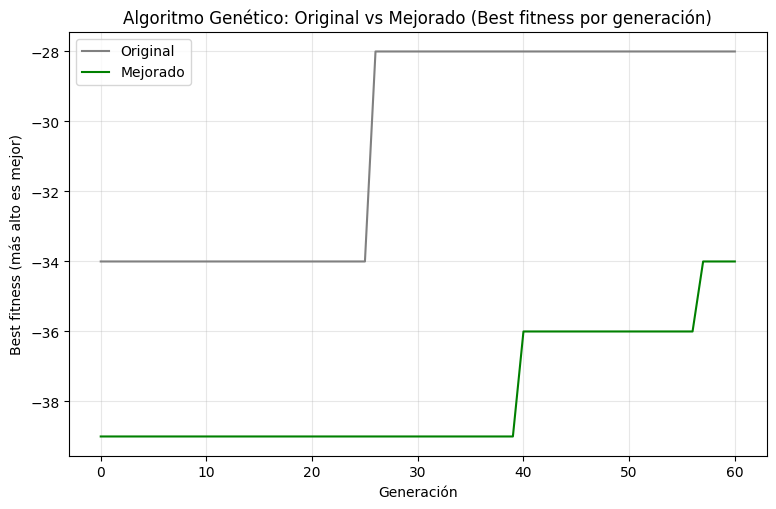

==== RESUMEN ====
Original : Best=-28.00 | NFE=5490 | Tiempo=2.178s
Mejorado : Best=-34.00 | NFE=6120 | Tiempo=3.705s


In [ ]:
import time, random, math
import numpy as np
import matplotlib.pyplot as plt


# 0) Secuencias base

SEQ_A = "PLEASANTLY"
SEQ_B = "MEANLY"



# 1) SCORING: BLOSUM62 o simple (match/mismatch)

USE_BLOSUM = True
try:
    from Bio.SubsMat.MatrixInfo import blosum62
    BLOSUM = blosum62
except Exception:
    USE_BLOSUM = False
    BLOSUM = None

GAP_OPEN = -5
GAP_EXT  = -1

def blosum_score(a, b):
    key = (a, b)
    if key in BLOSUM:
        return BLOSUM[key]
    key = (b, a)
    if key in BLOSUM:
        return BLOSUM[key]
    return -1

def simple_score(a, b):
    return 1 if a == b else -1

def score_pairwise_alignment(alnA, alnB, use_blosum=USE_BLOSUM):
    """Evalúa el alineamiento con penalización afín de gaps."""
    assert len(alnA) == len(alnB)
    s = 0
    for a, b in zip(alnA, alnB):
        if a != '-' and b != '-':
            s += blosum_score(a, b) if use_blosum and BLOSUM else simple_score(a, b)

    def affine_gap_penalty(seq):
        total, i = 0, 0
        while i < len(seq):
            if seq[i] == '-':
                run = 1
                i += 1
                while i < len(seq) and seq[i] == '-':
                    run += 1
                    i += 1
                total += GAP_OPEN + GAP_EXT * (run - 1)
            else:
                i += 1
        return total

    s += affine_gap_penalty(alnA)
    s += affine_gap_penalty(alnB)
    return s

# 2) Representación y validación de integridad

def check_integrity(alnA, alnB, seqA=SEQ_A, seqB=SEQ_B):
    return alnA.replace('-', '') == seqA and alnB.replace('-', '') == seqB

def random_embed(seq, total_len):
    """Inserta gaps aleatorios manteniendo orden."""
    assert total_len >= len(seq)
    gaps = total_len - len(seq)
    idxs = sorted(np.random.choice(np.arange(total_len), size=len(seq), replace=False))
    s = ['-'] * total_len
    for j, i in enumerate(idxs):
        s[i] = seq[j]
    return ''.join(s)

def initial_population(pop_size, seqA=SEQ_A, seqB=SEQ_B, max_extra=5, same_len=True):
    pop = []
    base_len = max(len(seqA), len(seqB)) + max_extra
    for _ in range(pop_size):
        a = random_embed(seqA, base_len)
        b = random_embed(seqB, base_len)
        pop.append((a, b))
    return pop


# 3) Operadores: cruza, mutación, reparación

rng = np.random.default_rng(2025)

def k_point_crossover(pair, k=2):
    a, b = pair
    L = len(a)
    if L < 2:
        return (a, b)
    k = min(k, L - 1)
    cuts = np.sort(rng.choice(np.arange(1, L), size=k, replace=False))
    toggle, ca, cb, last = False, [], [], 0
    for c in list(cuts) + [L]:
        if not toggle:
            ca.append(a[last:c]); cb.append(b[last:c])
        else:
            ca.append(b[last:c]); cb.append(a[last:c])
        toggle = not toggle
        last = c
    return (''.join(ca), ''.join(cb))

def shift_window(s, start, length, step):
    """Desplaza una ventana sin salirse de límites."""
    n = len(s)
    if n == 0 or length <= 0:
        return s
    start = max(0, min(start, n-1))
    length = max(1, min(length, n - start))
    new_start = start + step
    new_start = max(0, min(new_start, n - length))
    if new_start == start:
        return s
    window = s[start:start+length]
    s_wo = s[:start] + s[start+length:]
    return s_wo[:new_start] + window + s_wo[new_start:]

def mutate_gaps(s, pm_block=0.05, max_block=3):
    """Mutación segura de gaps: inserta, elimina o desplaza bloques."""
    # 1) Insertar bloque
    if rng.random() < pm_block:
        L = len(s)
        block_len = int(rng.integers(1, max(2, max_block+1)))
        pos = int(rng.integers(0, L + 1))
        s = s[:pos] + ('-' * block_len) + s[pos:]

    # 2) Eliminar parte de bloque
    if rng.random() < pm_block and '-' in s:
        runs = []
        i = 0
        while i < len(s):
            if s[i] == '-':
                j = i
                while j < len(s) and s[j] == '-': j += 1
                runs.append((i, j))
                i = j
            else:
                i += 1
        if runs:
            (i, j) = runs[int(rng.integers(0, len(runs)))]
            cut = int(rng.integers(1, (j - i) + 1))
            s = s[:i] + s[i+cut:]

    # 3) Desplazar ventana
    if rng.random() < pm_block and len(s) >= 2:
        n = len(s)
        start = int(rng.integers(0, n - 1))
        max_len = min(max_block, n - start)
        length = int(rng.integers(1, max_len + 1))
        step = int(rng.choice([-1, +1]))
        s = shift_window(s, start, length, step)
    return s

def repair_same_length(a, b):
    if len(a) < len(b): a = a + '-' * (len(b) - len(a))
    if len(b) < len(a): b = b + '-' * (len(a) - len(b))
    return a, b


# 4) Evaluación con NFE exacto

class Evaluator:
    def __init__(self, use_blosum=USE_BLOSUM):
        self.nfe = 0
        self.use_blosum = use_blosum
    def eval(self, individual):
        self.nfe += 1
        return score_pairwise_alignment(individual[0], individual[1], self.use_blosum)

def evaluate_population(pop, ev):
    return np.array([ev.eval(ind) for ind in pop], dtype=float)


# 5) Selección

def tournament_select(pop, fits, k=3):
    idx = np.random.randint(0, len(pop), size=k)
    return pop[idx[np.argmax(fits[idx])]]

def rank_sus_select(pop, fits):
    order = np.argsort(fits)
    ranks = np.empty_like(order)
    ranks[order] = np.arange(1, len(pop)+1)
    probs = ranks / ranks.sum()
    cum = np.cumsum(probs)
    r = rng.random()
    i = np.searchsorted(cum, r)
    return pop[i]


# 6) GA ORIGINAL

def ga_original(pop_size=80, generations=60, seed=2025,
                crossover_rate=0.9, mutation_rate_block=0.05,
                k_points=2, elitism=2, max_extra=5):
    random.seed(seed); np.random.seed(seed)
    ev = Evaluator()
    pop = initial_population(pop_size, max_extra=max_extra, same_len=True)
    pop = [repair_same_length(a,b) for a,b in pop]
    fits = evaluate_population(pop, ev)
    best_hist = [np.max(fits)]

    for g in range(generations):
        elite_idx = np.argsort(fits)[-elitism:]
        elites = [pop[i] for i in elite_idx]
        new_pop = elites.copy()
        while len(new_pop) < pop_size:
            p1 = tournament_select(pop, fits, k=3)
            p2 = tournament_select(pop, fits, k=3)
            if np.random.rand() < crossover_rate:
                child1 = k_point_crossover(p1, k=min(k_points,2))
                child2 = k_point_crossover(p2, k=min(k_points,2))
            else:
                child1, child2 = p1, p2
            if np.random.rand() < mutation_rate_block:
                child1 = (mutate_gaps(child1[0]), mutate_gaps(child1[1]))
            if np.random.rand() < mutation_rate_block:
                child2 = (mutate_gaps(child2[0]), mutate_gaps(child2[1]))
            c1a, c1b = repair_same_length(child1[0], child1[1])
            c2a, c2b = repair_same_length(child2[0], child2[1])
            if check_integrity(c1a, c1b): new_pop.append((c1a, c1b))
            if len(new_pop) < pop_size and check_integrity(c2a, c2b):
                new_pop.append((c2a, c2b))
        pop = new_pop[:pop_size]
        fits = evaluate_population(pop, ev)
        best_hist.append(np.max(fits))
    return best_hist, np.max(fits), ev.nfe


# 7) GA MEJORADO

def ga_mejorado(pop_size=80, generations=60, seed=2025,
                crossover_rate=0.95, base_mut_block=0.05,
                max_k=5, elitism=4, patience=10,
                immigrants_frac=0.15, max_extra=6):
    random.seed(seed); np.random.seed(seed)
    ev = Evaluator()
    pop = initial_population(pop_size, max_extra=max_extra, same_len=True)
    pop = [repair_same_length(a,b) for a,b in pop]
    fits = evaluate_population(pop, ev)
    best_hist = [np.max(fits)]
    best_so_far = best_hist[-1]
    no_improve = 0

    for g in range(generations):
        elite_idx = np.argsort(fits)[-elitism:]
        elites = [pop[i] for i in elite_idx]
        elite_pool = elites + elites

        # Diversidad robusta
        def diversity(pop):
            sample_idx = rng.choice(len(pop), size=min(20, len(pop)), replace=False)
            seqs = [pop[i][0] for i in sample_idx]
            maxlen = max(len(s) for s in seqs)
            seqs_norm = [s.ljust(maxlen, '-') for s in seqs]
            diffs, pairs = 0, 0
            for i in range(len(seqs_norm)):
                for j in range(i+1, len(seqs_norm)):
                    diffs += sum(c1 != c2 for c1,c2 in zip(seqs_norm[i], seqs_norm[j]))
                    pairs += maxlen
            return diffs / max(1, pairs)

        div = diversity(pop)
        mut_block = base_mut_block * (1.5 if div < 0.08 else 1.0)

        new_pop = elites.copy()
        while len(new_pop) < pop_size:
            if rng.random() < 0.7:
                k = 3 if g < generations//2 else 5
                p1 = tournament_select(pop + elite_pool, np.concatenate([fits, fits[elite_idx], fits[elite_idx]]), k=k)
                p2 = tournament_select(pop + elite_pool, np.concatenate([fits, fits[elite_idx], fits[elite_idx]]), k=k)
            else:
                p1 = rank_sus_select(pop, fits)
                p2 = rank_sus_select(pop, fits)
            if rng.random() < crossover_rate:
                kp = int(rng.integers(2, max(3, max_k+1)))
                child1 = k_point_crossover(p1, k=kp)
                child2 = k_point_crossover(p2, k=kp)
            else:
                child1, child2 = p1, p2
            if rng.random() < mut_block:
                child1 = (mutate_gaps(child1[0], pm_block=mut_block),
                          mutate_gaps(child1[1], pm_block=mut_block))
            if rng.random() < mut_block:
                child2 = (mutate_gaps(child2[0], pm_block=mut_block),
                          mutate_gaps(child2[1], pm_block=mut_block))
            c1a, c1b = repair_same_length(child1[0], child1[1])
            c2a, c2b = repair_same_length(child2[0], child2[1])
            if check_integrity(c1a, c1b): new_pop.append((c1a, c1b))
            if len(new_pop) < pop_size and check_integrity(c2a, c2b):
                new_pop.append((c2a, c2b))
        pop = new_pop[:pop_size]
        fits = evaluate_population(pop, ev)
        current_best = np.max(fits)
        if current_best <= best_so_far + 1e-9:
            no_improve += 1
        else:
            best_so_far = current_best
            no_improve = 0
        if no_improve >= patience:
            m = int(max(1, immigrants_frac * pop_size))
            worst_idx = np.argsort(fits)[:m]
            for wi in worst_idx:
                ni = initial_population(1, max_extra=6, same_len=True)[0]
                pop[wi] = repair_same_length(ni[0], ni[1])
            fits = evaluate_population(pop, ev)
            no_improve = 0
        best_hist.append(np.max(fits))
    return best_hist, np.max(fits), ev.nfe


# 8) EXPERIMENTO: Original vs Mejorado

SEED = 2025
params_orig = dict(pop_size=90, generations=60, seed=SEED,
                   crossover_rate=0.9, mutation_rate_block=0.05, k_points=2,
                   elitism=2, max_extra=5)

params_mej  = dict(pop_size=90, generations=60, seed=SEED,
                   crossover_rate=0.95, base_mut_block=0.05, max_k=6,
                   elitism=6, patience=8, immigrants_frac=0.20, max_extra=6)

t0 = time.time()
hist_o, best_o, nfe_o = ga_original(**params_orig)
t1 = time.time()
hist_m, best_m, nfe_m = ga_mejorado(**params_mej)
t2 = time.time()

time_o = t1 - t0
time_m = t2 - t1


# 9) Gráfica comparativa

gens = np.arange(len(hist_o))
plt.figure(figsize=(9,5.5))
plt.plot(gens, hist_o, label="Original", color="gray")
plt.plot(gens, hist_m, label="Mejorado", color="green")
plt.title("Algoritmo Genético: Original vs Mejorado (Best fitness por generación)")
plt.xlabel("Generación"); plt.ylabel("Best fitness (más alto es mejor)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


# 10) Resumen numérico

print("==== RESUMEN ====")
print(f"Original : Best={best_o:.2f} | NFE={nfe_o} | Tiempo={time_o:.3f}s")
print(f"Mejorado : Best={best_m:.2f} | NFE={nfe_m} | Tiempo={time_m:.3f}s")
